<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/tutorials/W1D3_GeneralizedLinearModels/student/W1D3_Tutorial2.ipynb" target="_blank"><img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"/></a>   <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W1D3_GeneralizedLinearModels/student/W1D3_Tutorial2.ipynb" target="_blank"><img alt="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"/></a>

## Regresión logística y regularizaciones

---
### Objetivos

En el primer notebook vimos que son los GLMs e implementamos el de Poisson, comparándolo con la regresión lineal. Ahora, implementaremos la regresión logística, un caso especial de GLMs utilizado para modelar resultados binarios.
A menudo, la variable que deseas predecir solo toma uno de dos posibles valores. ¿Izquierda o derecha? ¿Despierto o dormido? ¿Coche o autobús? La idea va a ser decodificar las decisiones de izquierda/derecha de un ratón a partir de datos de trenes de disparos

---
# Configuración

##  Instalar e importar gadget de retroalimentación


In [ ]:
# @title Install and import feedback gadget

!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_cn",
            "user_key": "y1x3mpx5",
        },
    ).render()


feedback_prefix = "W1D3_T2"

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.1 MB/s eta 0:00:00


In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

##  Ajustes de Figuras


In [ ]:
# @title Figure settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

##  Funciones para Graficar

In [ ]:
# @title Plotting Functions

def plot_weights(models, sharey=True):
  """Draw a stem plot of weights for each model in models dict."""
  n = len(models)
  f = plt.figure(figsize=(10, 2.5 * n))
  axs = f.subplots(n, sharex=True, sharey=sharey)
  axs = np.atleast_1d(axs)

  for ax, (title, model) in zip(axs, models.items()):

    ax.margins(x=.02)
    stem = ax.stem(model.coef_.squeeze())
    stem[0].set_marker(".")
    stem[0].set_color(".2")
    stem[1].set_linewidths(.5)
    stem[1].set_color(".2")
    stem[2].set_visible(False)
    ax.axhline(0, color="C3", lw=3)
    ax.set(ylabel="Weight", title=title)
  ax.set(xlabel="Neuron (a.k.a. feature)")
  f.tight_layout()
  plt.show()


def plot_function(f, name, var, points=(-10, 10)):
    """Evaluate f() on linear space between points and plot.

    Args:
      f (callable): function that maps scalar -> scalar
      name (string): Function name for axis labels
      var (string): Variable name for axis labels.
      points (tuple): Args for np.linspace to create eval grid.
    """
    x = np.linspace(*points)
    ax = plt.figure().subplots()
    ax.plot(x, f(x))
    ax.set(
      xlabel=f'${var}$',
      ylabel=f'${name}({var})$'
    )
    plt.show()


def plot_model_selection(C_values, accuracies):
  """Plot the accuracy curve over log-spaced C values."""
  ax = plt.figure().subplots()
  ax.set_xscale("log")
  ax.plot(C_values, accuracies, marker="o")
  best_C = C_values[np.argmax(accuracies)]
  ax.set(
      xticks=C_values,
      xlabel="C",
      ylabel="Cross-validated accuracy",
      title=f"Best C: {best_C:1g} ({np.max(accuracies):.2%})",
  )
  plt.show()


def plot_non_zero_coefs(C_values, non_zero_l1, n_voxels):
  """Plot the accuracy curve over log-spaced C values."""
  ax = plt.figure().subplots()
  ax.set_xscale("log")
  ax.plot(C_values, non_zero_l1, marker="o")
  ax.set(
    xticks=C_values,
    xlabel="C",
    ylabel="Number of non-zero coefficients",
  )
  ax.axhline(n_voxels, color=".1", linestyle=":")
  ax.annotate("Total\n# Neurons", (C_values[0], n_voxels * .98), va="top")
  plt.show()

##  Recuperación y carga de datos


In [ ]:
#@title Data retrieval and loading
import os
import requests
import hashlib

url = "https://osf.io/r9gh8/download"
fname = "W1D4_steinmetz_data.npz"
expected_md5 = "d19716354fed0981267456b80db07ea8"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    elif hashlib.md5(r.content).hexdigest() != expected_md5:
      print("!!! Data download appears corrupted !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

def load_steinmetz_data(data_fname=fname):

  with np.load(data_fname) as dobj:
    data = dict(**dobj)

  return data

---

# Sección 1: Regresión Logística

La Regresión Logística es un modelo de clasificación binaria. Es un GLM con una función de enlace *logístico* y un modelo de ruido *Bernoulli* (es decir, lanzamiento de moneda).

Al igual que en la notebook anterior, la regresión logística implica un procedimiento estándar:

1. Definir un *modelo* de cómo se relacionan las entradas con las salidas.
2. Ajustar los parámetros para maximizar la probabilidad (logarítmica) de tus datos dados tu modelo.

## Sección 1.1: El modelo de regresión logística

La ecuación fundamental de entrada/salida de la regresión logística es:

\begin{equation}
\hat{y} \equiv p(y=1|x,\theta) = \sigma(\theta^\top x)
\end{equation}

Nótese que interpretamos la salida de la regresión logística, $\hat{y}$, como la **probabilidad de que y = 1** dado las entradas $x$ y los parámetros $\theta$.

Aquí $\sigma(\cdot)$ es una función de "compresión" llamada **función sigmoide** o **función logística**. Su salida está en el rango $0 \leq y \leq 1$. Se ve así:

\begin{equation}
\sigma(z) = \frac{1}{1 + \textrm{exp}(-z)}
\end{equation}

Recuerda que $z = \theta^\top x$. Los parámetros deciden si $\theta^\top x$ será muy negativo, en cuyo caso $\sigma(\theta^\top x)\approx 0$, o muy positivo, lo que significa $\sigma(\theta^\top x)\approx 1$.
</details>

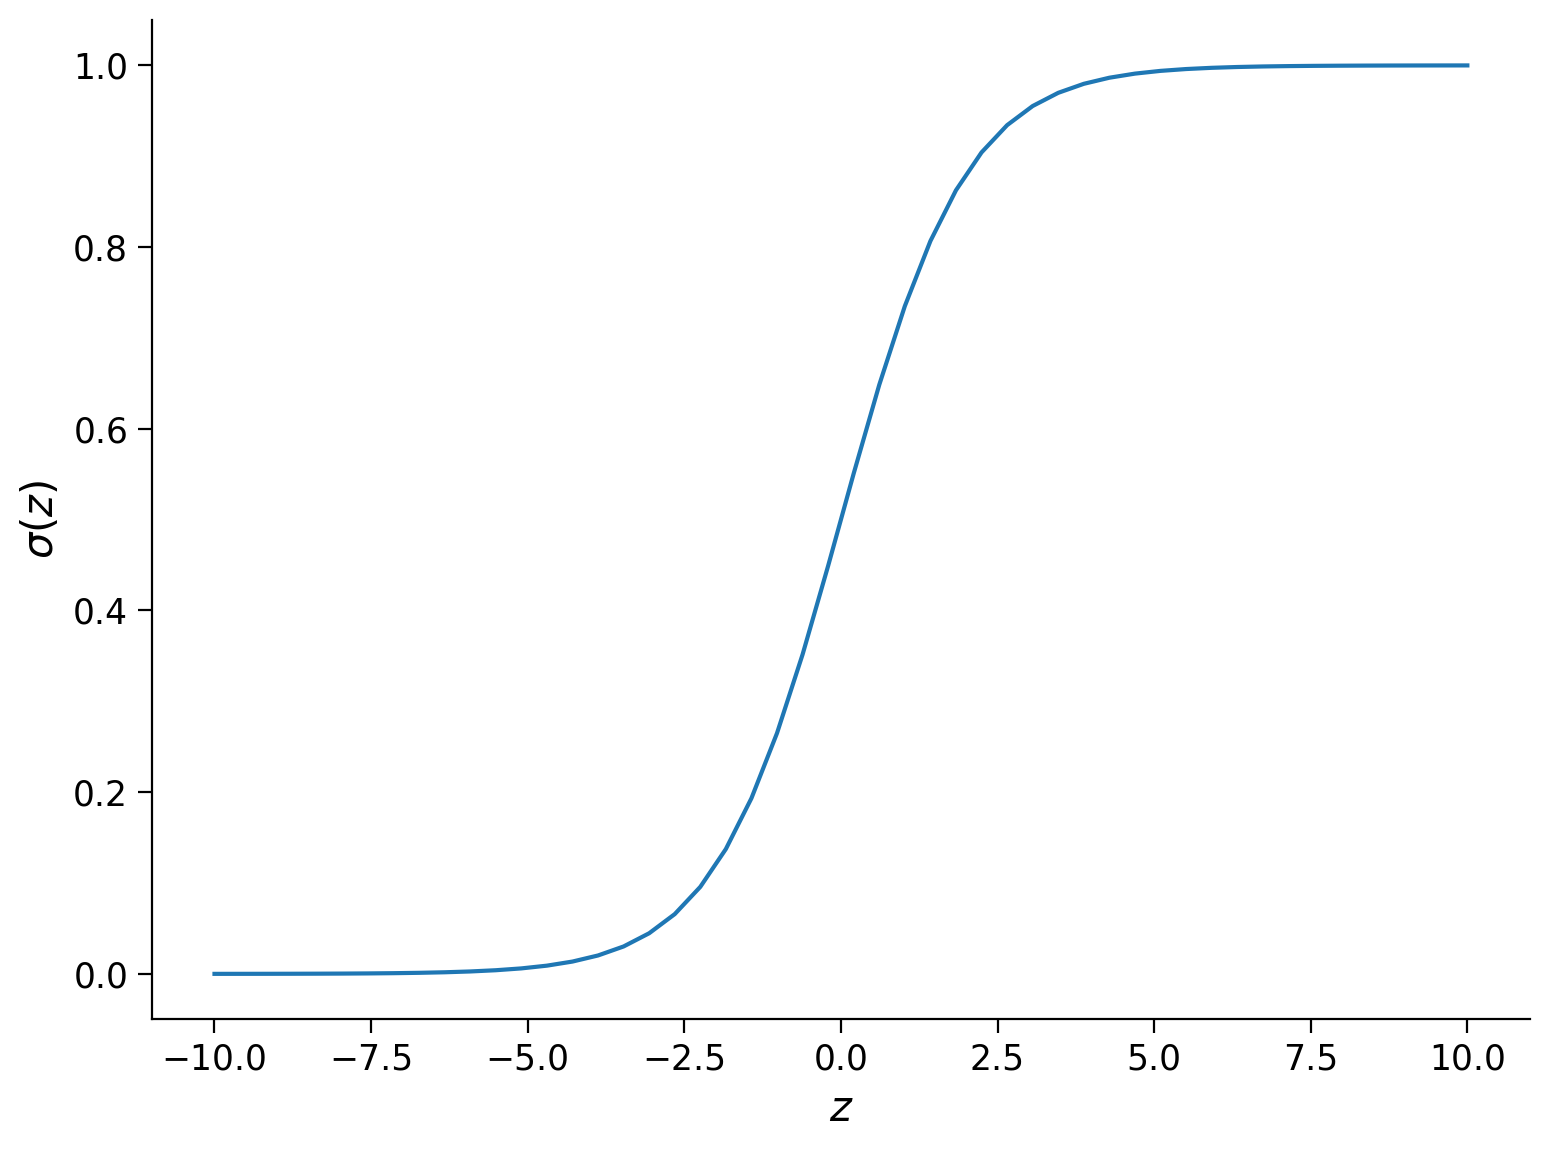

In [ ]:
#@title Ejemplo de la función sigmoide
def sigmoid(z):
  """Return the logistic transform of z."""

  sigmoid = 1 / (1 + np.exp(-z))

  return sigmoid

# Visualize
plot_function(sigmoid, "\sigma", "z", (-10, 10))

## Sección 1.2: Uso de scikit-learn

A diferencia del notebook anterior, no vamos a escribir el código que implementa todo el modelo de Regresión Logística por nosotros mismos. En su lugar, utilizaremos la implementación en [scikit-learn](https://scikit-learn.org/stable/), una librería muy popular para Aprendizaje Automático.

El objetivo de esta próxima sección es introducir los clasificadores de `scikit-learn` y entender cómo aplicarlos a datos neuronales reales.

---
# Sección 2: Decodificación de datos neuronales con regresión logística

## Sección 2.1: Preparación de los datos

En esta notebook utilizaremos el conjunto de datos de Steinmetz que ya has visto anteriormente. Recuerda que este conjunto de datos incluye grabaciones de neuronas mientras los ratones realizan una tarea de decisión.

Los ratones tenían la tarea de girar una rueda para indicar si percibían un estímulo de Gabor a la izquierda, a la derecha o en absoluto. Sondas Neuropixel midieron picos a través de la corteza. Consulta el siguiente esquema de la tarea a continuación del preimpreso de BiorXiv.




 Execute to see schematic


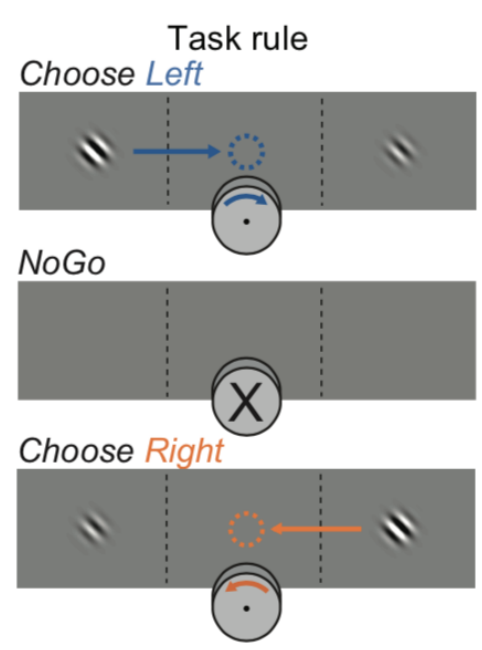

In [ ]:
# @markdown Execute to see schematic
import IPython
IPython.display.Image("http://kordinglab.com/images/others/steinmetz-task.png")

Hoy vamos a **decodificar la decisión a partir de datos neuronales** utilizando la Regresión Logística. Solo consideraremos ensayos en los que el ratón eligió "Izquierda" o "Derecha" e ignoraremos los ensayos de NoGo.

### Formato de los datos

En la celda oculta `Recuperación y carga de datos`, hay una función que carga los datos:

- `spikes`: un arreglo de tasas de disparos normalizados con forma `(n_trials, n_neurons)`
- `choices`: un vector de 0s y 1s, que indica la respuesta conductual del animal, con longitud `n_trials`.

In [ ]:
data = load_steinmetz_data()
for key, val in data.items():
  print(key, val.shape)

spikes (276, 691)
choices (276,)


Al igual que con los GLM que has visto en el tutorial anterior (Regresión Lineal y de Poisson), necesitaremos dos estructuras de datos:

- una matriz `X` con forma `(n_samples, n_features)`
- un vector `y` con longitud `n_samples`.

En la notebook anterior, `y` correspondía a los datos neuronales, y `X` correspondía a algo sobre el experimento. Aquí, vamos a invertir esas relaciones. Eso es lo que hace que este sea un modelo de *decodificación*: vamos a predecir el comportamiento (`y`) a partir de las respuestas neuronales (`X`):

In [ ]:
y = data["choices"]
X = data["spikes"]

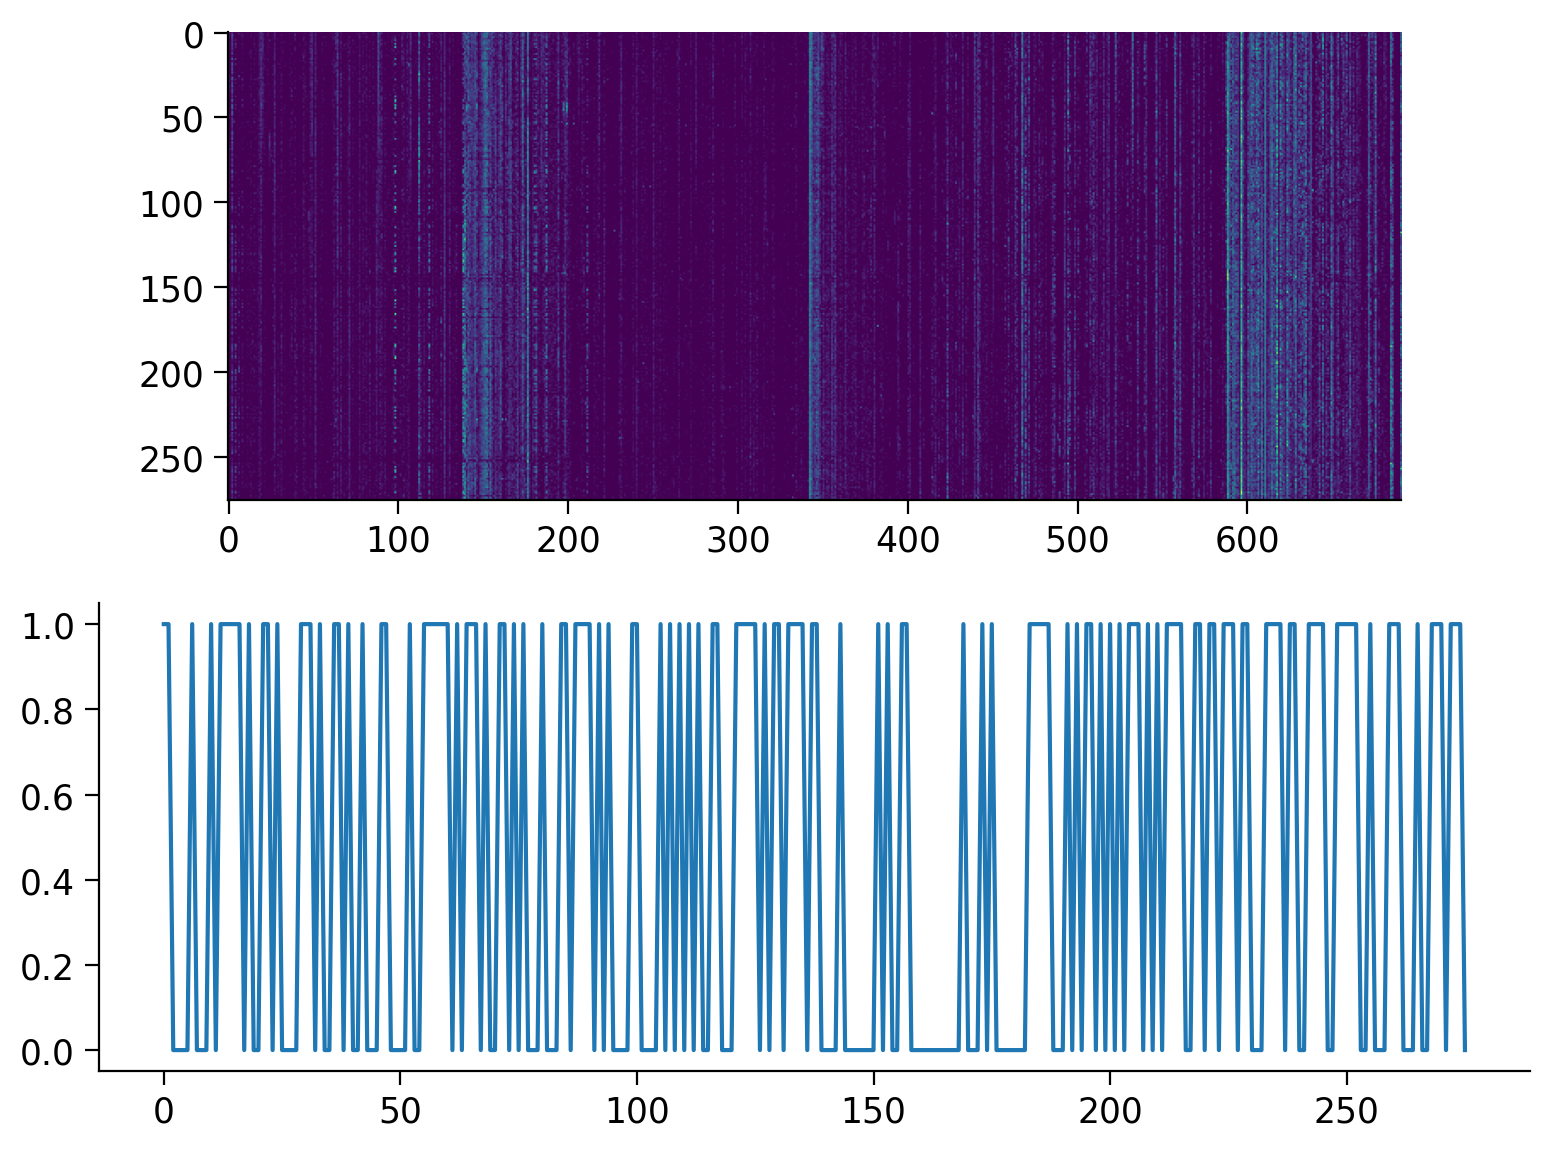

In [ ]:
plt.subplot(211)
plt.imshow(X)
plt.subplot(212)
plt.plot(y)

## Sección 2.2: Ajuste del modelo

Ajustamos un modelo de Regresión Logística usando `scikit-learn`

In [ ]:
# Define the model
log_reg = LogisticRegression(penalty=None)

# Fit it to data
log_reg.fit(X, y)

LogisticRegression(penalty=None)

Hay dos pasos aquí:

- *Inicializamos* el modelo con un hiperparámetro, indicándole qué penalización usar (nos enfocaremos en esto en la segunda parte de la notebook).
- *Ajustamos* el modelo pasándole los objetos `X` y `y`.



## Sección 2.3: Clasificación de los datos de entrenamiento

Ajustar el modelo realiza una optimización de máxima verosimilitud, aprendiendo un conjunto de *pesos de características*. Podemos usar esos pesos aprendidos para *clasificar* nuevos datos o predecir las etiquetas para cada muestra:

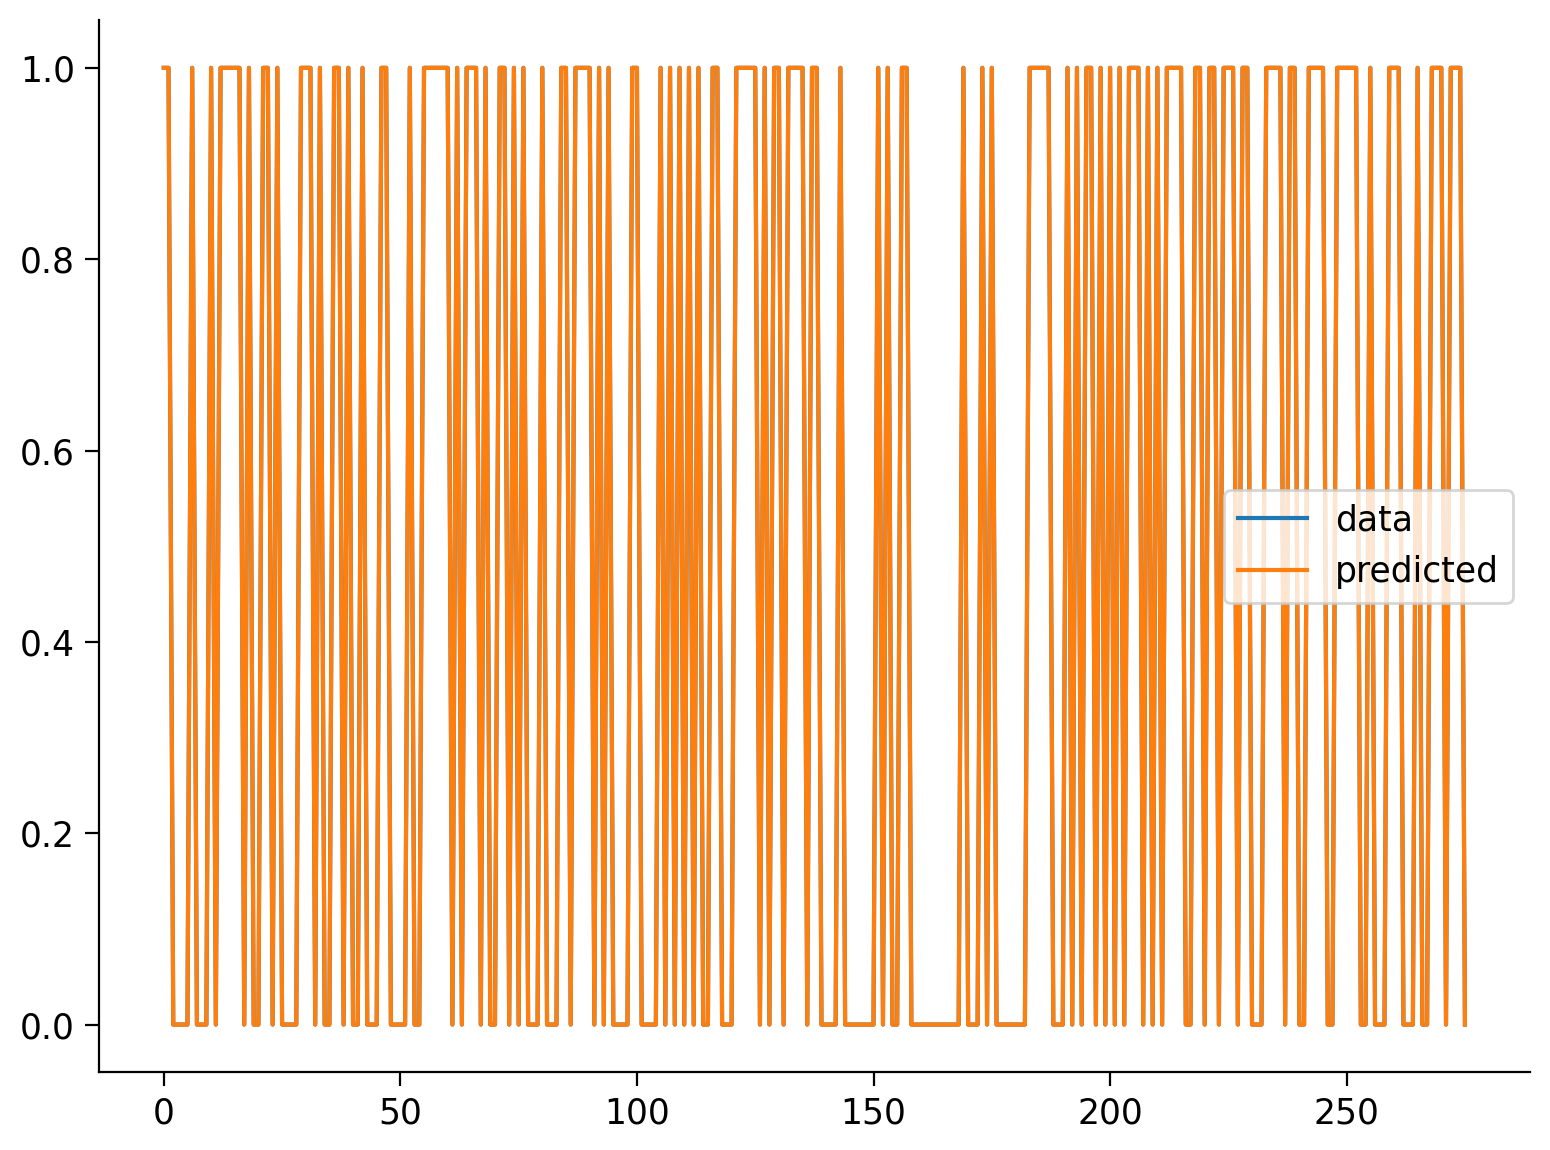

In [ ]:
y_pred = log_reg.predict(X)

plt.plot(y,label='data')
plt.plot(y_pred,label='predicted')
plt.legend()

¿Hay algo raro no?

## Sección 2.4: Evaluación del modelo

Ahora, necesitamos evaluar las predicciones del modelo. Utilizaremos un puntaje de *exactitud* (i.e. accuracy) para este propósito. La exactitud de un clasificador se determina por la proporción de ensayos correctos, donde la etiqueta predicha coincide con la etiqueta verdadera, del total de ensayos.

### Exactitud del clasificador

Para el primer ejercicio, implementa una función para evaluar un clasificador utilizando el puntaje de exactitud. Úsalo para obtener la exactitud del clasificador en los datos de *entrenamiento*.

In [ ]:
def compute_accuracy(X, y, model):
  """Compute accuracy of classifier predictions.

  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    model (sklearn estimator): Classifier with trained weights.

  Returns:
    accuracy (float): Proportion of correct predictions.
  """

  y_pred = model.predict(X)

  accuracy = (y == y_pred).sum() / len(y)

  return accuracy


# Compute train accuracy
train_accuracy = compute_accuracy(X, y, log_reg)
print(f"Accuracy on the training data: {train_accuracy:.2%}")

Accuracy on the training data: 100.00%


## Sección 2.5: Validación cruzada del clasificador


### Validación cruzada utilizando funciones de ayuda de `scikit-learn`

`scikit-learn` ofrece una serie de [funciones útiles](https://scikit-learn.org/stable/model_selection.html) que pueden hacer validación cruzada por nosotros. Por ejemplo, puedes validar cruzadamente un clasificador utilizando `cross_val_score`.

`cross_val_score` toma un modelo de `sklearn` como `LogisticRegression`, así como tus datos `X` y `y`. Luego, reentrena tu modelo en divisiones de prueba/entrenamiento de `X` y `y`, y devuelve la exactitud de prueba en cada uno de los conjuntos de prueba.

In [ ]:
accuracies = cross_val_score(LogisticRegression(penalty=None), X, y, cv=8)  # k=8 cross validation

Ejecutar para graficar estas puntuaciones de exactitud `k=8`.

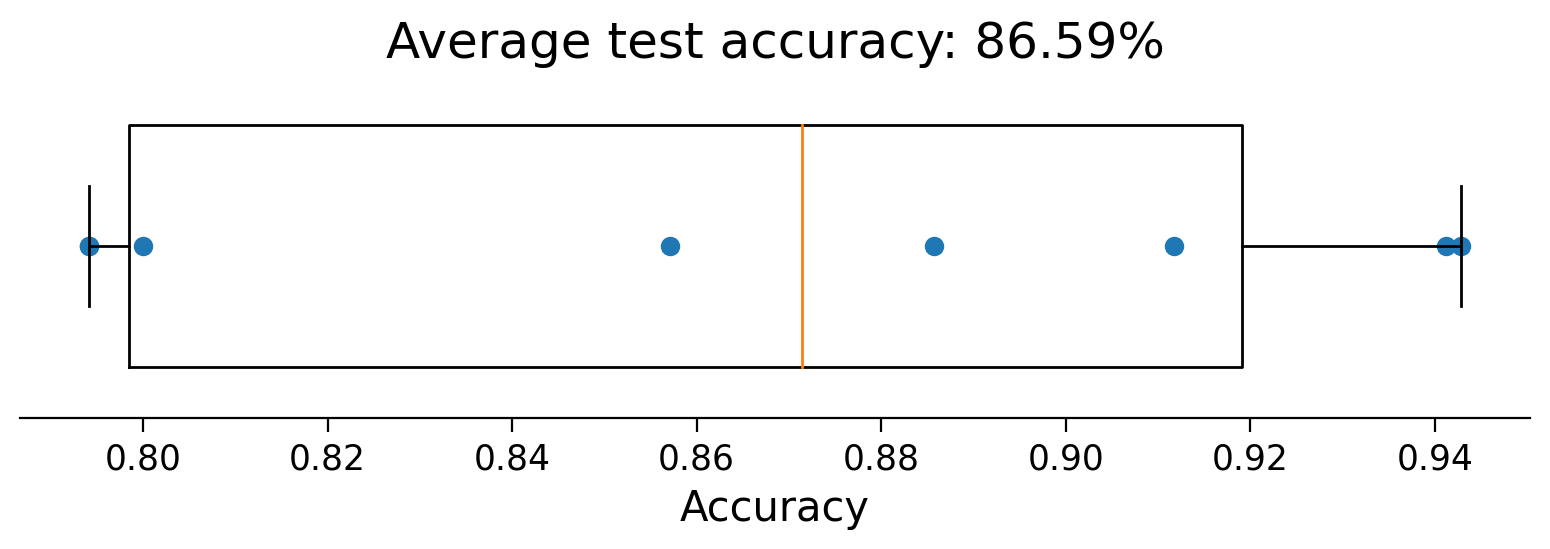

In [ ]:
# @markdown Run to plot out these `k=8` accuracy scores.
f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies, vert=False, widths=.7)
ax.scatter(accuracies, np.ones(8))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {accuracies.mean():.2%}"
)
ax.spines["left"].set_visible(False)
plt.show()

La menor exactitud validada cruzadamente en comparación con la exactitud de entrenamiento (100%) sugiere que el modelo está siendo *sobreajustado*. ¿Es esto sorprendente? Piensa en la forma de la matriz $X$:

In [ ]:
print(X.shape)

(276, 691)


El modelo tiene casi tres veces más características que muestras. O sea que estamos **sobreajustando**!


-----

# Sección 3: Regularización

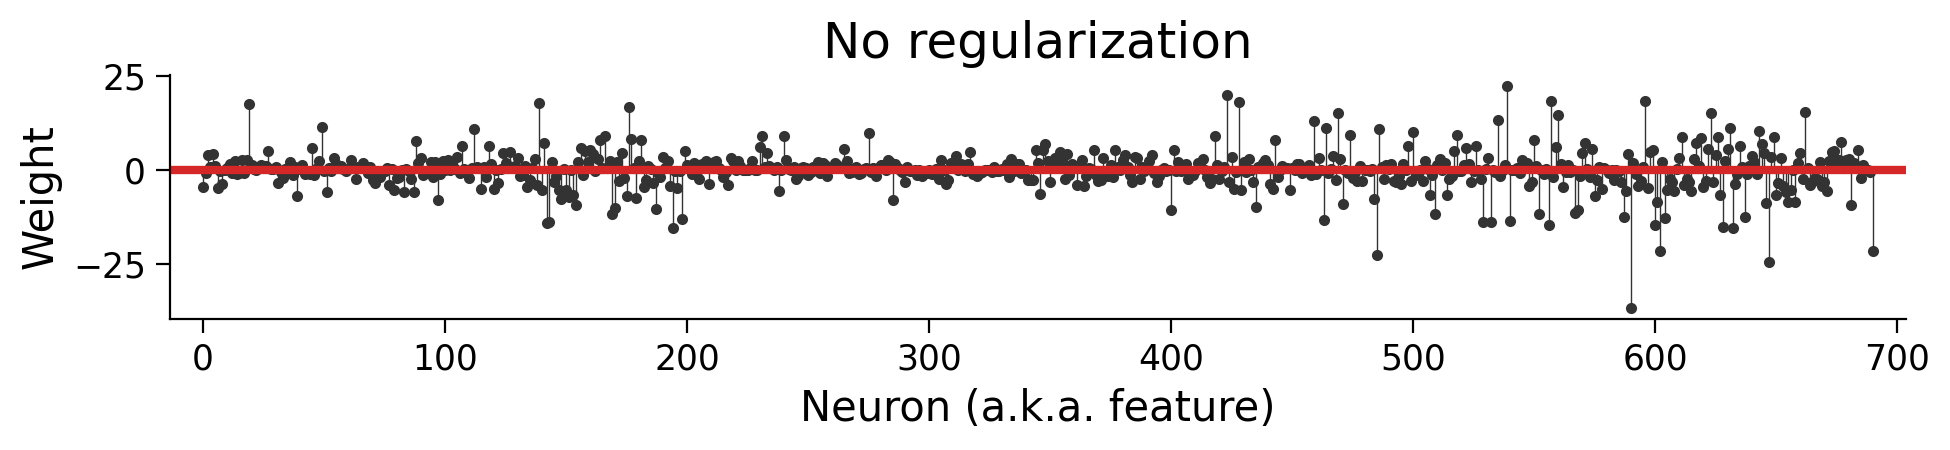

In [ ]:
log_reg = LogisticRegression(penalty=None).fit(X, y)
plot_weights({"No regularization": log_reg})

Es importante entender este gráfico. Cada punto visualiza un valor en nuestro vector de parámetros $\theta$. (Es el mismo estilo de gráfico que el que muestra $\theta$ en el video). Dado que cada característica es la respuesta promedio en el tiempo de una neurona, cada punto muestra cómo el modelo utiliza cada neurona para estimar una decisión.

Nota la escala del eje y. Algunas neuronas tienen valores de alrededor de $20$, mientras que otras llegan a $-20$.

## Sección 3.1: Regularización $L_2$

La regularización viene en diferentes formas. Una muy común utiliza una penalización $L_2$ o *Ridge*. Esto cambia la función objetivo a

\begin{equation}
-\log\mathcal{L}'(\theta | X, y)= -\log\mathcal{L}(\theta | X, y) +\frac\beta2\sum_i\theta_i^2,
\end{equation}

donde $\beta$ es un *hiperparámetro* que establece la *fuerza* de la regularización.

Puedes usar regularización en `scikit-learn` cambiando la penalidad (`penalty`), y puedes establecer la fuerza de la regularización con el hiperparámetro `C` ($C = \frac{1}{\beta}$, así que esto establece la *inversa* de la regularización).

Comparemos los pesos del clasificador no regularizado con los pesos del clasificador cuando usamos el `C` predeterminado de 1:

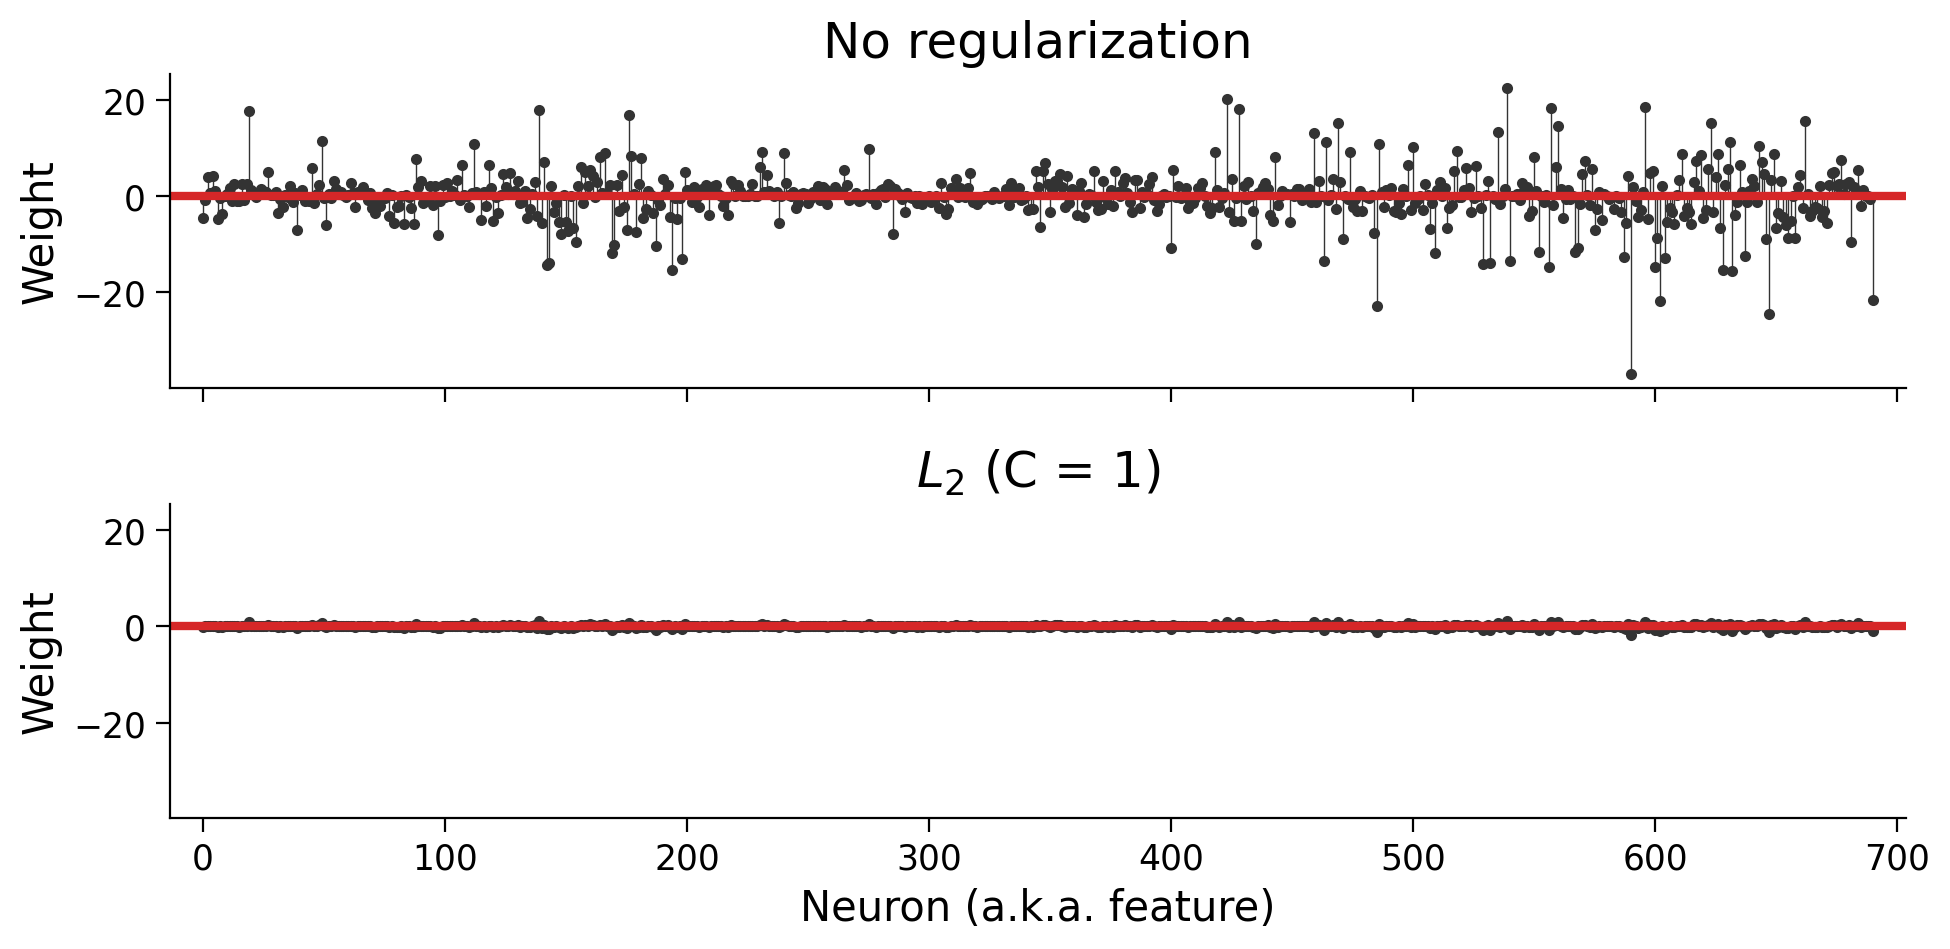

In [ ]:
log_reg_l2 = LogisticRegression(penalty="l2", C=1).fit(X, y)

# now show the two models
models = {
  "No regularization": log_reg,
  "$L_2$ (C = 1)": log_reg_l2,
}
plot_weights(models)

Usando la misma escala para los dos ejes y, es casi imposible ver los pesos $L_2$. Permitamos que las escalas del eje y se ajusten a cada conjunto de pesos:

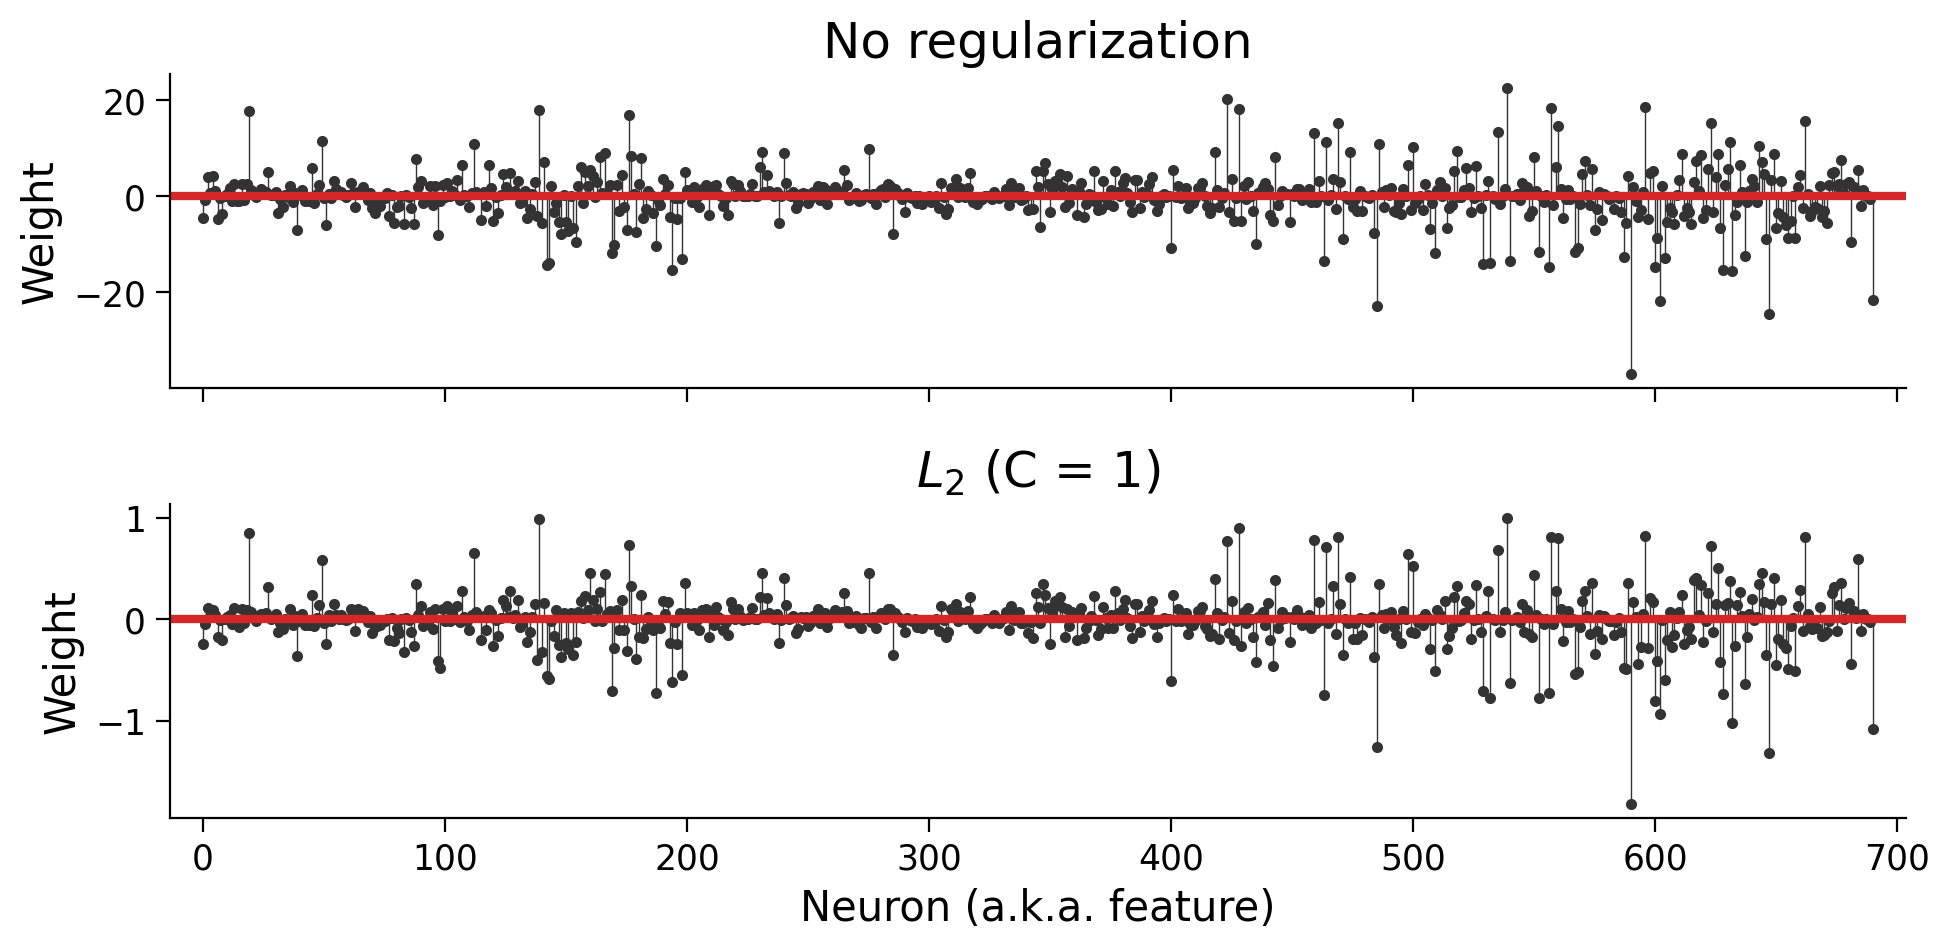

In [ ]:
plot_weights(models, sharey=False)

Ahora puedes ver que los pesos tienen el mismo patrón básico, pero los pesos regularizados son un orden de magnitud más pequeños.

### Demo Interactiva 3.1: El efecto de variar C en el tamaño del parámetro

Podemos usar este mismo enfoque para ver cómo los pesos dependen de la *fuerza* de la regularización:

 ¡Ejecuta esta celda para habilitar el widget!

In [ ]:
# @markdown Execute this cell to enable the widget!

# Precompute the models so the widget is responsive
log_C_steps = 1, 11, 1
penalized_models = {}
for log_C in np.arange(*log_C_steps, dtype=int):
  m = LogisticRegression("l2", C=10 ** log_C, max_iter=5000)
  penalized_models[log_C] = m.fit(X, y)

@widgets.interact
def plot_observed(log_C = widgets.IntSlider(value=1, min=1, max=10, step=1)):
  models = {
    "No regularization": log_reg,
    f"$L_2$ (C = $10^{{{log_C}}}$)": penalized_models[log_C]
  }
  plot_weights(models)

interactive(children=(IntSlider(value=1, description='log_C', max=10, min=1), Output()), _dom_classes=('widget…

Recuerda que $C=\frac1\beta$, por lo que un $C$ mayor significa menos regularización. El panel superior corresponde a $C \rightarrow \infty$.

## Sección 3.2: Regularización $L_1$

$L_2$ no es la única opción para la regularización. También está la penalización $L_1$, o "Lasso". Esto cambia la función objetivo a

\begin{equation}
-\log\mathcal{L}'(\theta | X, y) = -\log\mathcal{L}(\theta | X, y) +\frac\beta2\sum_i|\theta_i|
\end{equation}

En la práctica, usar la suma de los valores absolutos de los pesos provoca *dispersión*: en lugar de solo hacerse más pequeños, algunos de los pesos se verán forzados a $0$:

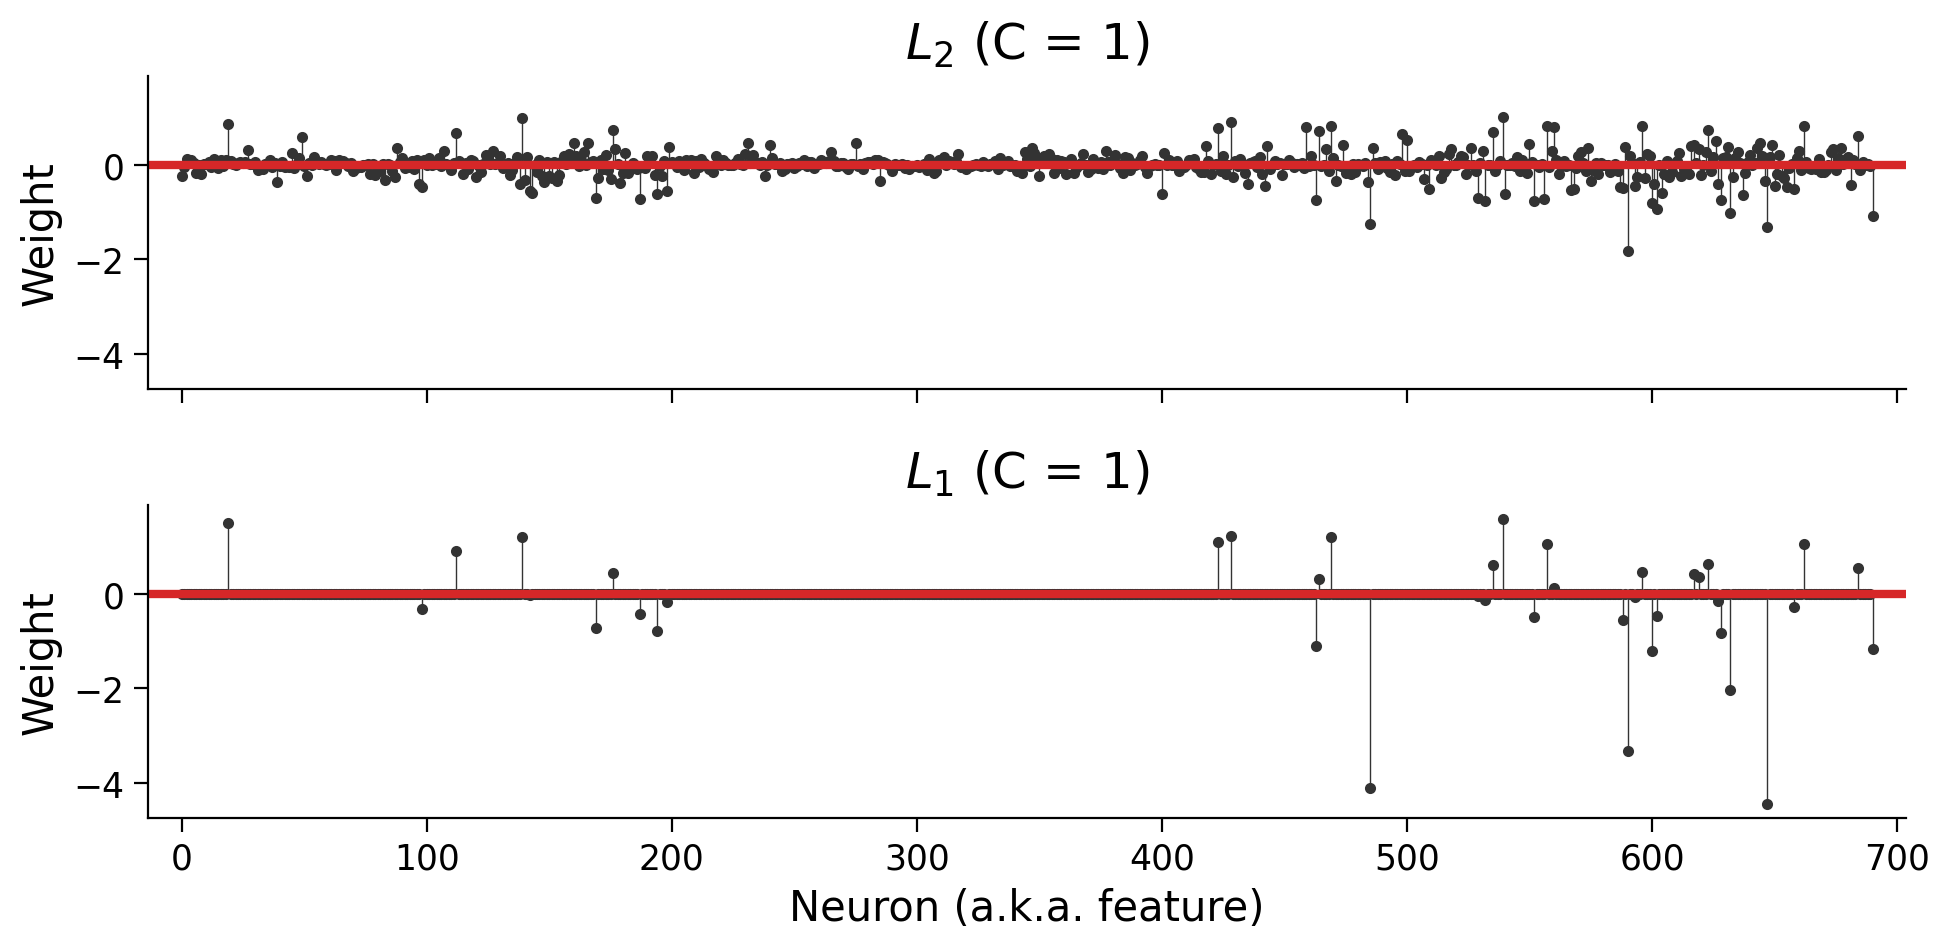

In [ ]:
log_reg_l1 = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000)
log_reg_l1.fit(X, y)
models = {
  "$L_2$ (C = 1)": log_reg_l2,
  "$L_1$ (C = 1)": log_reg_l1,
}
plot_weights(models)

Nota: Notarás que hemos añadido dos parámetros adicionales: `solver="saga"` y `max_iter=5000`. La clase `LogisticRegression` puede usar varios algoritmos de optimización diferentes ("solvers"), y no todos ellos admiten la penalización $L_1$. En cierto punto, el solver se rendirá si no ha encontrado un valor mínimo. El parámetro `max_iter` le indica que haga más intentos; de lo contrario, veríamos una fea advertencia sobre la "convergencia".

### El efecto de la regularización $L_1$ en la dispersión de parámetros

Usaermos la siguiente función para ajustar un modelo `LogisticRegression` regularizado y devolver **el número de coeficientes en el vector de parámetros que son iguales a 0**.


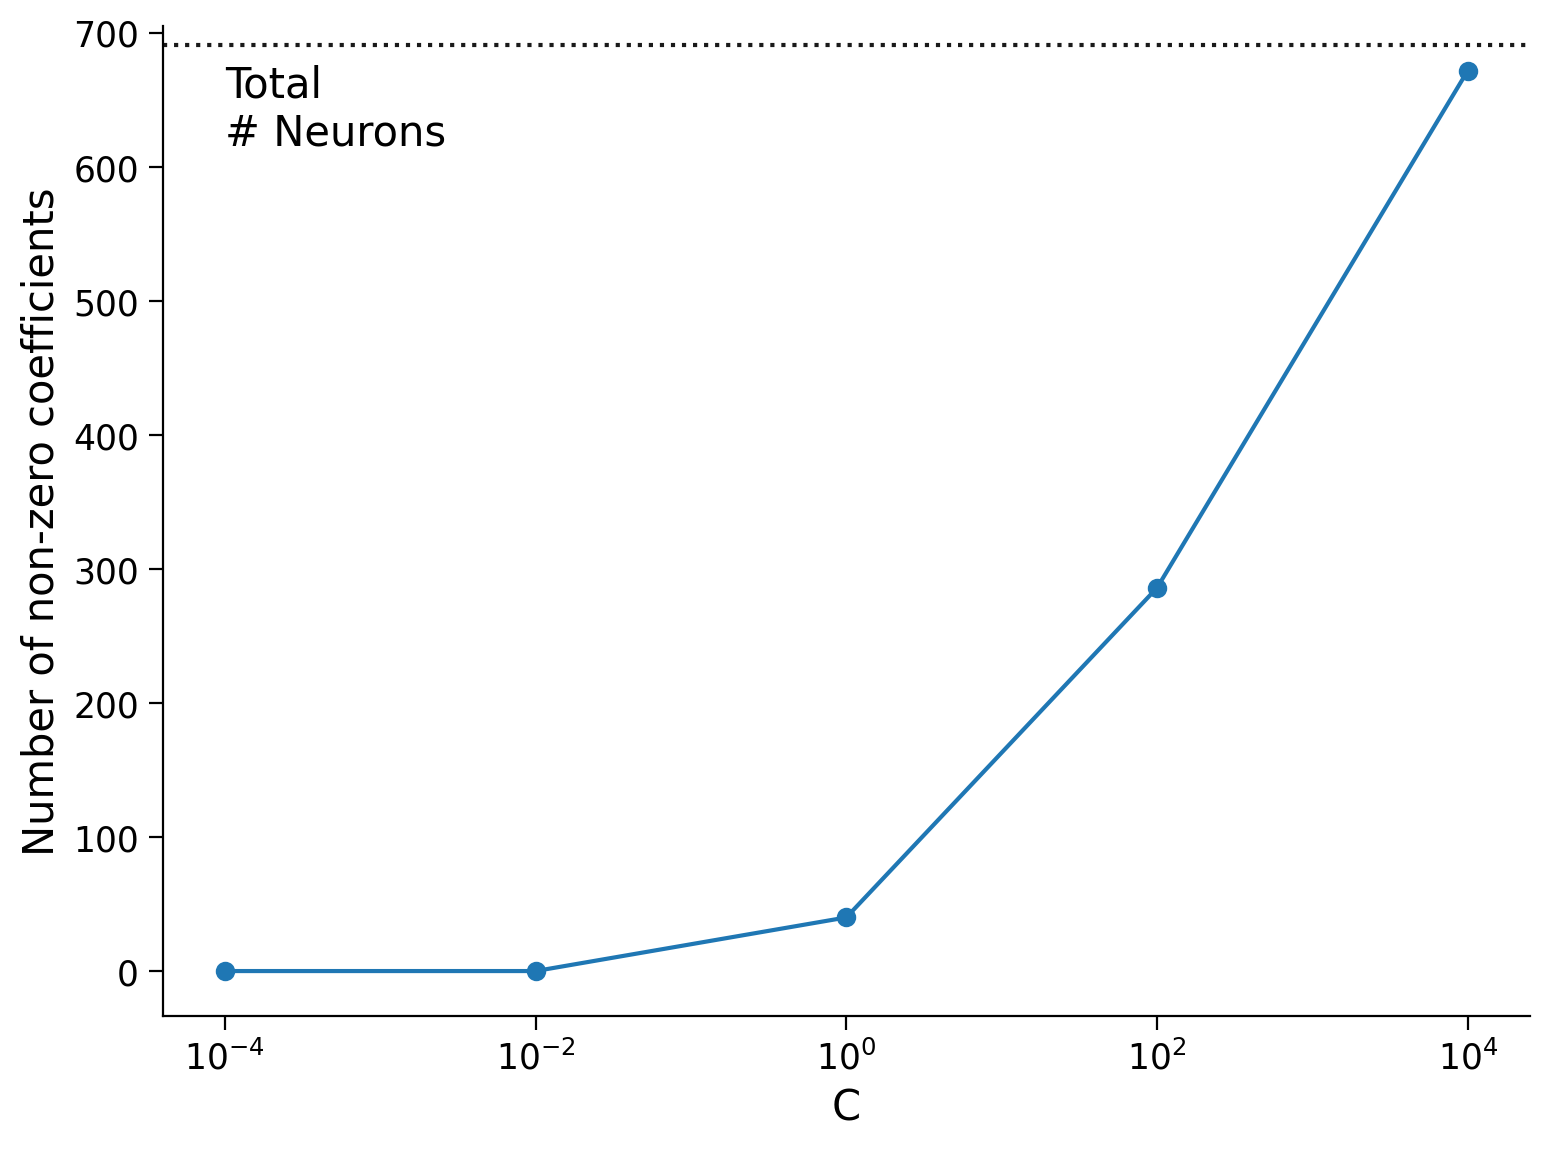

In [ ]:
def count_non_zero_coefs(X, y, C_values):
  """Fit models with different L1 penalty values and count non-zero coefficients.

  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    C_values (1D array): List of hyperparameter values

  Returns:
    non_zero_coefs (list): number of coefficients in each model that are nonzero

  """
  non_zero_coefs = []
  for C in C_values:

    # Initialize and fit the model
    # (Hint, you may need to set max_iter)
    model = LogisticRegression(penalty="l1", C=C, solver="saga", max_iter=5000)
    model.fit(X,y)

    # Get the coefs of the fit model (in sklearn, we can do this using model.coef_)
    coefs = model.coef_

    # Count the number of non-zero elements in coefs
    non_zero = np.sum(coefs != 0)
    non_zero_coefs.append(non_zero)

  return non_zero_coefs


# Use log-spaced values for C
C_values = np.logspace(-4, 4, 5)

# Count non zero coefficients
non_zero_l1 = count_non_zero_coefs(X, y, C_values)

# Visualize
plot_non_zero_coefs(C_values, non_zero_l1, n_voxels=X.shape[1])

Un $C$ más pequeño (un $\beta$ mayor) conduce a soluciones más dispersas.

**Vinculación con la neurociencia**: ¿Cuándo está bien asumir que el vector de parámetros es disperso? Siempre que sea cierto que la mayoría de las características no afectan el resultado. Un caso de uso podría ser la decodificación de características visuales de bajo nivel a partir de fMRI de todo el cerebro: podríamos esperar que solo los voxels en V1 y el tálamo se usen en la predicción.

**ADVERTENCIA**: Cuidado al interpretar $\theta$. Nunca interpretes los coeficientes no nulos como *evidencia* de que solo esos voxels/neuronas/características llevan información sobre el resultado. Esto es un producto de nuestro esquema de regularización, y por lo tanto *nuestra suposición previa de que la solución es dispersa*. Otros tipos de regularización o modelos pueden encontrar relaciones muy distribuidas en todo el cerebro. Nunca uses un modelo como evidencia de un fenómeno cuando ese fenómeno está codificado en las suposiciones del modelo.

## Sección 3.4: Elección de la penalización por regularización

En los ejemplos anteriores, simplemente elegimos números arbitrarios para la fuerza de la regularización. ¿Cómo sabes qué valor del hiperparámetro usar?

La respuesta es la misma que cuando querés saber si has aprendido buenos valores de parámetros: usa la validación cruzada. El mejor hiperparámetro será aquel que permita al modelo generalizar mejor a datos no vistos.

### Ejercicio de Programación 3.4: Selección de modelo

En el ejercicio final, utilizaremos la validación cruzada para evaluar un conjunto de modelos, cada uno con una penalización $L_2$ diferente. La función `model_selection` tiene un bucle *for* que obtiene la exactitud promedio validada cruzadamente para cada valor de penalización (usa la función `cross_val_score` que presentamos anteriormente, con 8 divisiones).

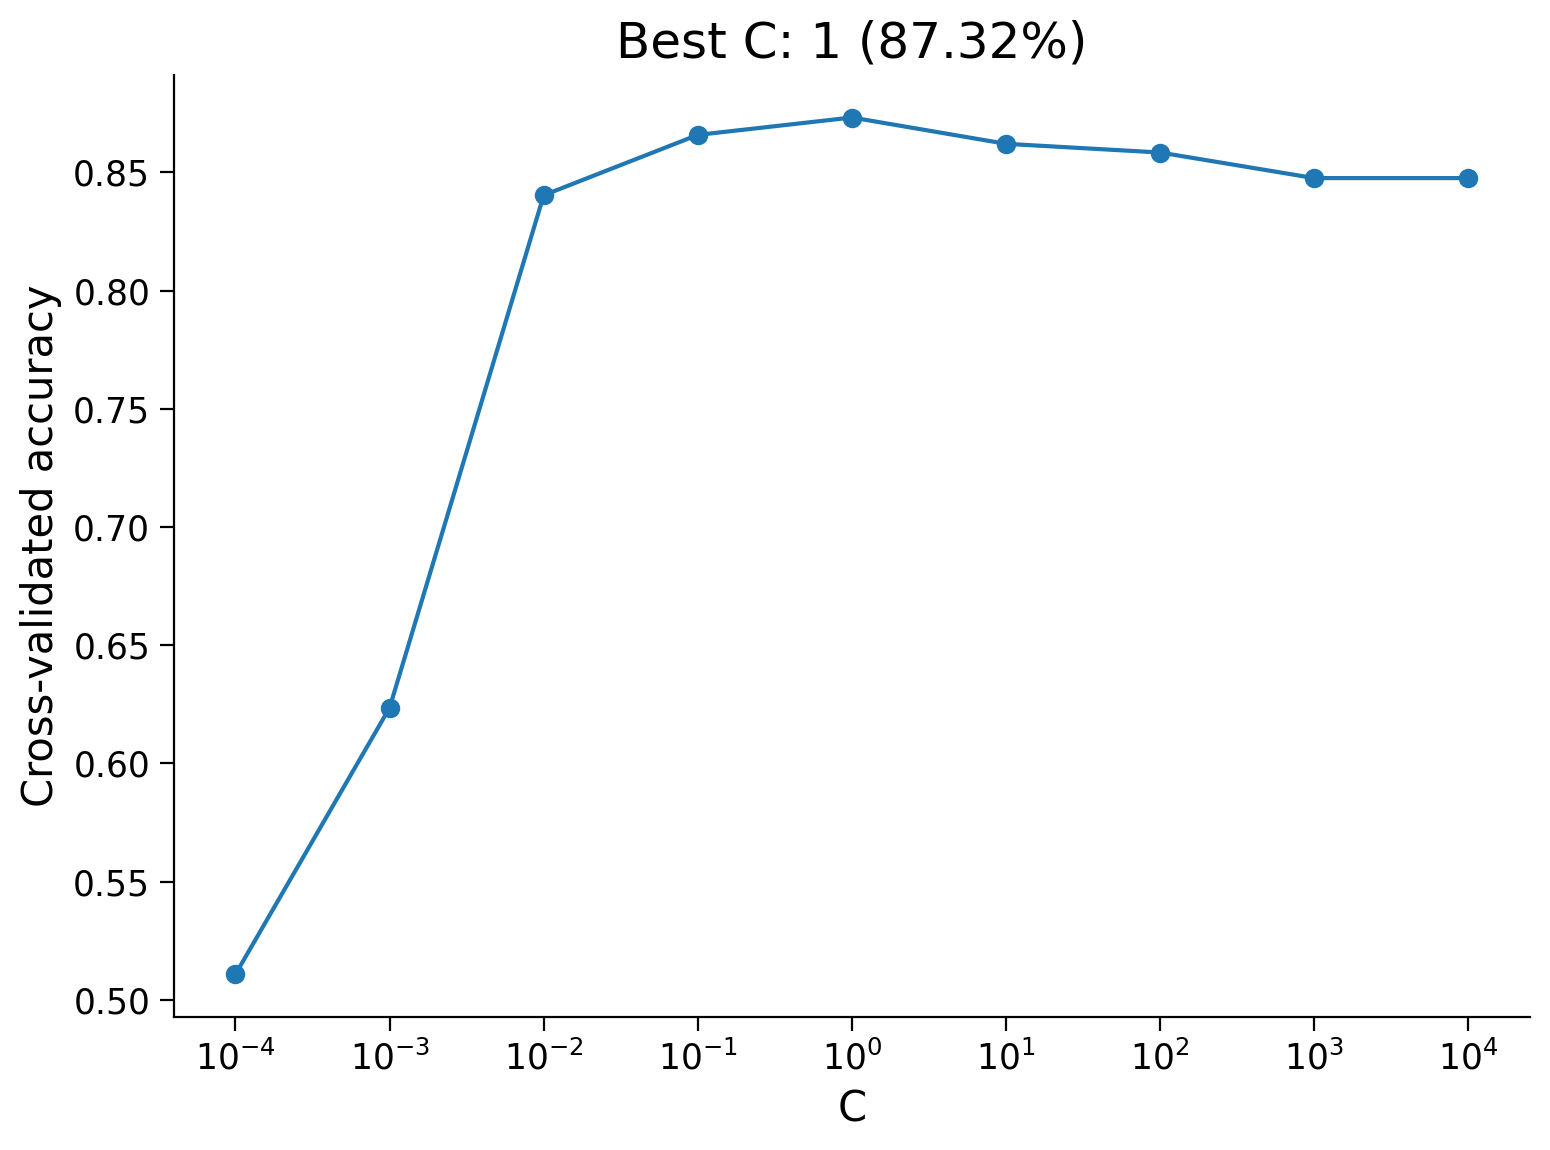

In [ ]:
def model_selection(X, y, C_values):
  """Compute CV accuracy for each C value.

  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    C_values (1D array): Array of hyperparameter values.

  Returns:
    accuracies (1D array): CV accuracy with each value of C.

  """
  accuracies = []
  for C in C_values:

    # Initialize and fit the model
    # (Hint, you may need to set max_iter)
    model = LogisticRegression(penalty="l2", C=C, max_iter=5000)

    # Get the accuracy for each test split using cross-validation
    accs = cross_val_score(model, X, y, cv=8)

    # Store the average test accuracy for this value of C
    accuracies.append(accs.mean())

  return accuracies


# Use log-spaced values for C
C_values = np.logspace(-4, 4, 9)

# Compute accuracies
accuracies = model_selection(X, y, C_values)

# Visualize
plot_model_selection(C_values, accuracies)

Este gráfico sugiere que el valor correcto de $C$ sí importa, hasta cierto punto. Recuerda que $C$ es la *inversa* de la regularización. El gráfico muestra que los modelos donde la regularización era demasiado fuerte (valores pequeños de $C$) tuvieron un rendimiento muy pobre. Para $C > 10^{-2}$, las diferencias son marginales, pero el mejor rendimiento se obtuvo con un valor intermedio ($C \approx 10^1$).
